# nCoV-2019

Data Source: 
    https://en.m.wikipedia.org/wiki/Timeline_of_the_2019–20_Wuhan_coronavirus_outbreak

In [2]:
# -*- coding: utf-8 -*-
"""
Created on Tue Jan 28 08:19:13 2020

"""

import datetime as dt

import warnings
warnings.filterwarnings("ignore")
#import time

#import packages
import pandas as pd
import numpy as np
import xlrd
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from scipy.optimize import curve_fit

import matplotlib.pyplot as plt
import pandas_datareader as pdr
from tabulate import tabulate
from matplotlib import style
from matplotlib.pylab import rcParams
style.use('fivethirtyeight')
#style.use('ggplot')


In [3]:
df_xls=pd.read_excel(r'Corona.xlsx')

#Eliminating sparse data
df=df_xls[7:]

In [4]:
df

,Date,Cases Suspected,Cases Confirmed,Deaths,Recovered,Quarantined,Quarantined & Released,Total,Source,Cases Confirm Outside China
7,2020.01.15,NaN,41.0,2.0,7.0,119.0,644.0,763.0,[10],NaN
8,2020.01.16,NaN,45.0,2.0,12.0,98.0,665.0,763.0,[11],NaN
9,2020.01.17,NaN,62.0,2.0,15.0,82.0,681.0,763.0,[12],NaN
10,2020.01.18,NaN,121.0,2.0,19.0,NaN,NaN,NaN,NaN,NaN
11,2020.01.19,NaN,198.0,3.0,25.0,90.0,727.0,817.0,[13],4.0
12,2020.01.20,54.0,291.0,6.0,25.0,922.0,817.0,1739.0,[14][15],6.0
13,2020.01.21,37.0,440.0,9.0,25.0,1394.0,765.0,2159.0,[16],8.0
14,2020.01.22,257.0,571.0,17.0,25.0,4928.0,969.0,5897.0,[17],14.0
15,2020.01.23,1072.0,830.0,25.0,34.0,8420.0,1087.0,9507.0,[18],25.0
16,2020.01.24,1965.0,1287.0,41.0,38.0,13967.0,1230.0,15197.0,[19],40.0


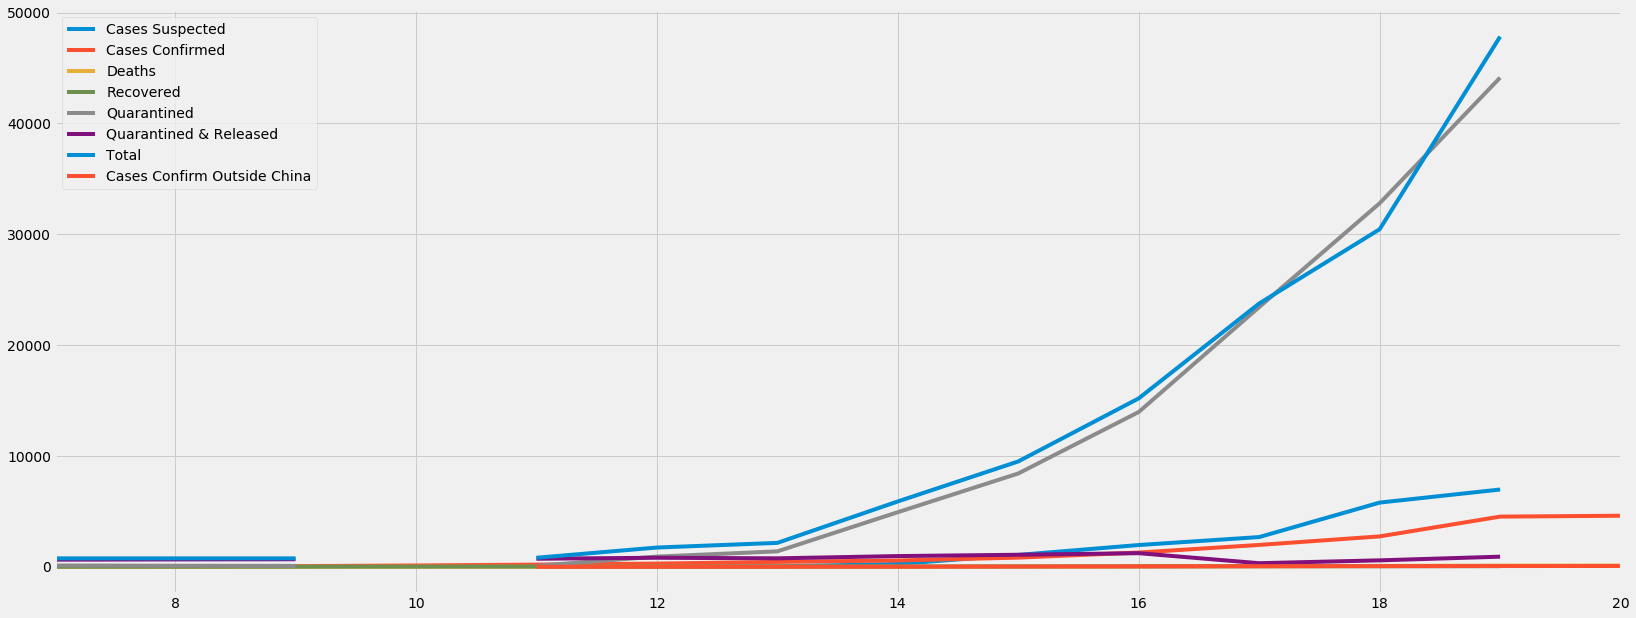

In [5]:
rcParams['figure.figsize'] = 25,10
df.plot()

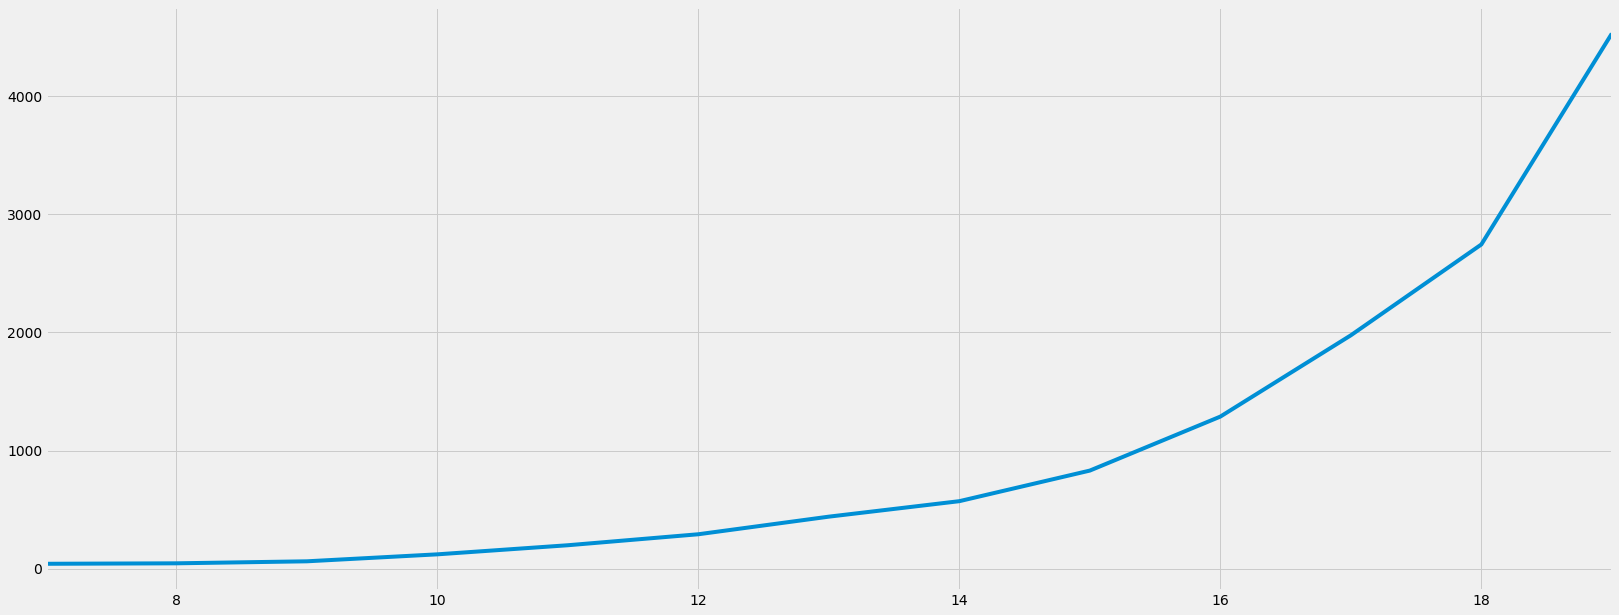

In [6]:
df_cc = df[:13]['Cases Confirmed']
df_cc.plot()

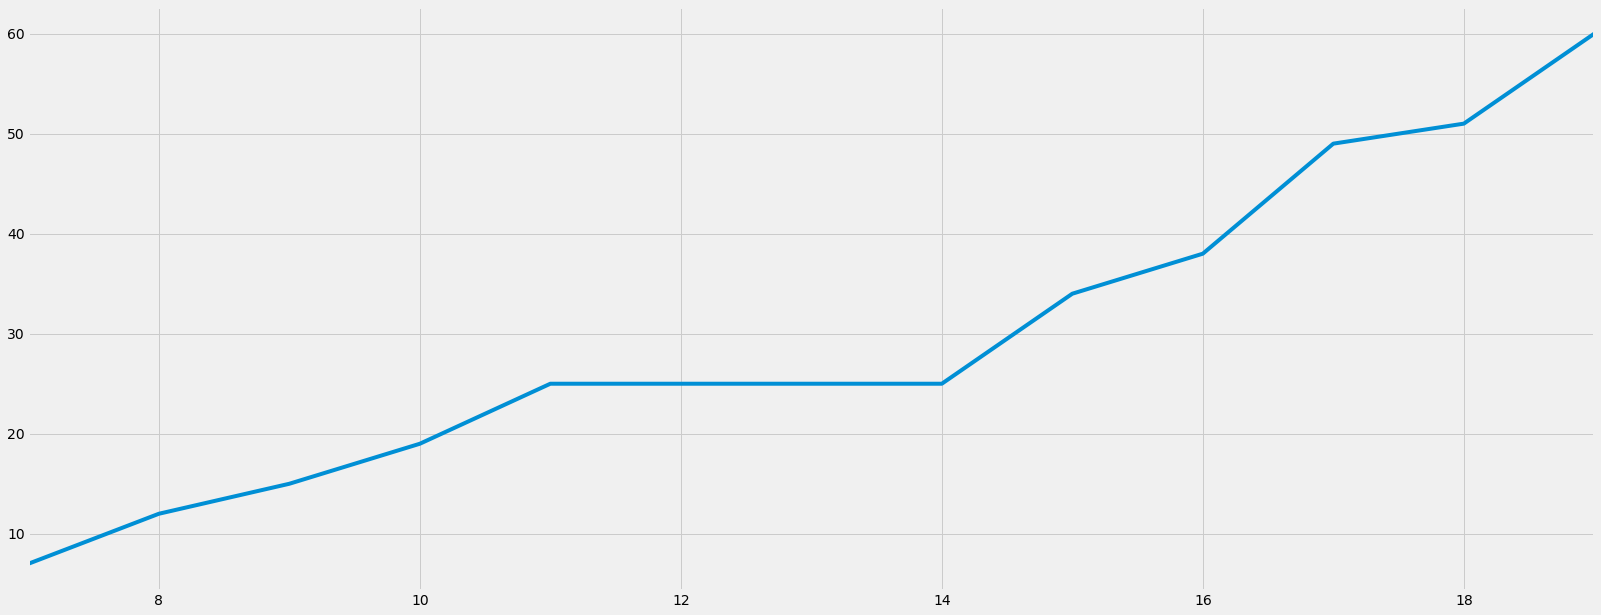

In [7]:
df_r = df[:13]['Recovered']
df_r.plot()

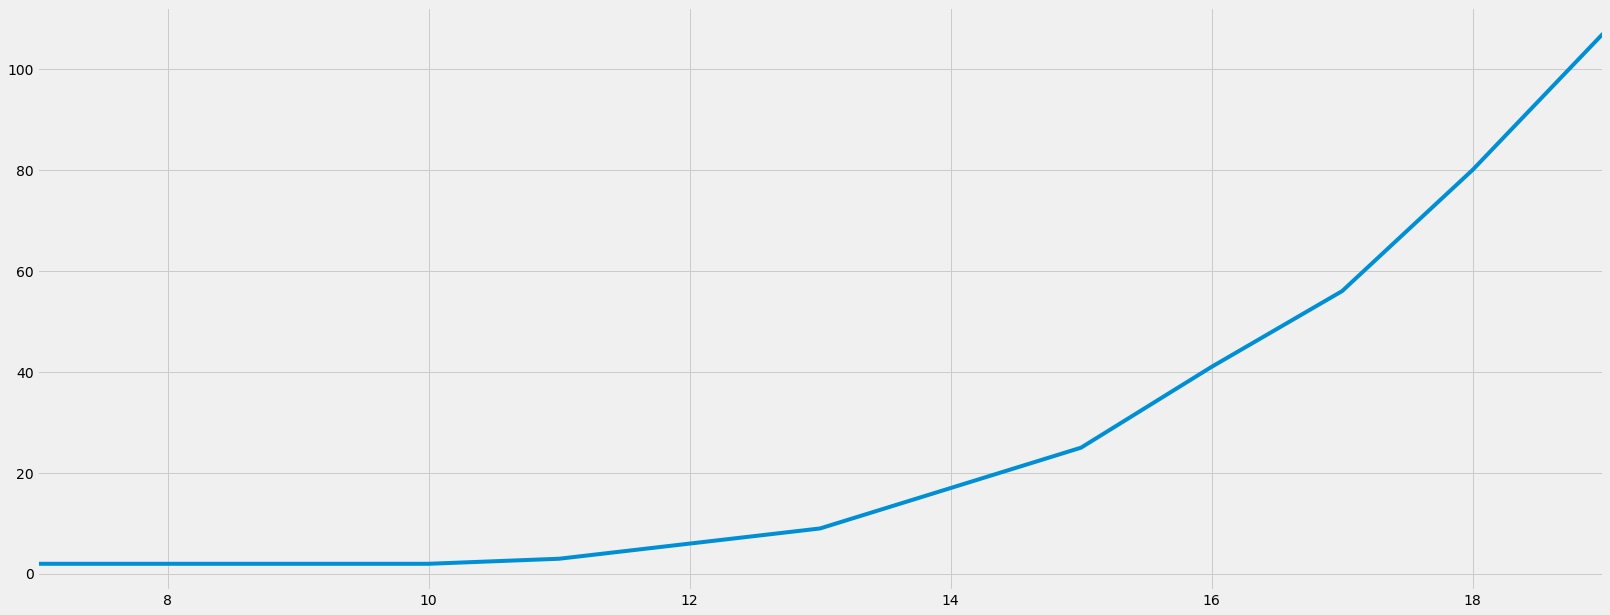

In [8]:
df_d = df[:13]['Deaths']
df_d.plot()